## Multi-Class Distributions
We define a set of multi-class distributions that are wrappers around sklearn classifiers and/or distributions  
They can be used for Bayesian Classification and for Likelihood Computations in HMMs / Decision Trees
Some are very simple wrappers around an existing sklearn Classifier.   
The API is largely derived from sklearn with the same data structures and methods.

In the NB variants (Dist_Gauss, Dist_Disc) everything is organized per feature
in the GMM case (Dist_GMM) organization is rather per class


#### Data and Classes

    X: ndarray (n_samples, n_features)   IS ALWAYS 2D
    y: ndarray (n_samples, )             IS ALWAYS 1D
        y is either integers (unnamed classes) or strings (named classes) 
        classes_ holds the class names, it is either inferred from training data or can be set
    
#### Methods (as in sklearn)

    .fit(X,y)               train from examples   
    .predict_proba(X)       computes class probabilities of feature vectors   
    .predict_log_proba(X)   computes class log probabilities of feature vectors   
    .predict(X)             computes predicted classes from X   

    .predict_ftr_prob(X)    computes feature likelihoods for X
    .predict_ftr_log_prob() computes feature log-likelihoods for X
    [.predict_prob(X)    computes feature likelihoods for X  -- will be deprecated]
    [.predict_log_prob() computes feature log-likelihoods for X -- will be deprecated]
    
#### Methods (added in pyspch)
    .print_model()          prints the key attributes of the model for each feature or per class
    .plot_model()           plots the distribution for each feature or per class
    
#### Attributes or methods
    classes_      class names   
    class_count_  class count from training data   
    class_prior_  class prior from training   


In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.light_palette("caramel",50,input="xkcd")
import pandas as pd

from IPython.display import display, HTML, clear_output
from scipy.special import logsumexp
from scipy.stats import norm

from pyspch.io.sequence_data import make_seq1, make_seq1d
import pyspch.Densities as SpchDens
import pyspch.display as Spchd

In [2]:
## obsolete class definitions, left around for backward testing
class Dist_Gauss(GaussianNB):
    def __str__(self):
        #return "Type what do you want to see here."
        return str(self.__dict__)
            
    def print_model(self):
        print('Means')
        print(self.theta_)
        print('Variance')
        print(self.var_)   
        
    def plot_model(self):
        nclass, n_features = self.theta_.shape
        f,ax = plt.subplots(1,n_features,figsize=(14,5))
        for j in range(n_features):
            for i in range(nclass):
                mu = self.theta_[i,j]
                sigma = np.sqrt(self.var_[i,j])
                xx = np.linspace(mu-2*sigma,mu+2*sigma,100)
                ax[j].plot(xx, norm.pdf(xx, mu, sigma))
            ax[j].legend(self.classes_)
            ax[j].set_title("Feature (%d)" %j)   
            
class Dist_Discr(CategoricalNB):
    """
    feature_log_prob_ : list of arrays of shape (n_features,)
        Each holds an array of shape (n_classes, n_categories of respective feature) for each feature.
    """
    def print_model(self,per_class=False):
        if per_class:
            n_classes = len(self.classes_)
            for i in range(n_classes): self.print_class(i)
        else:
            n_features = len(self.feature_log_prob_)
            for i in range(n_features): self.print_feature(i)
            
    def print_feature(self,feat_id):            
        print(" ++ Feature(%d) ++ "%feat_id)
        proba = np.exp(self.feature_log_prob_[feat_id])
        print(proba)

    def predict_log_prob(self,X):
        jll = np.zeros((X.shape[0], self.class_count_.shape[0]))
        for i in range(self.n_features_in_):
            indices = X[:, i]
            jll += self.feature_log_prob_[i][:, indices].T
        return jll
    
    def predict_prob(self,X):
        return( np.exp( self.predict_log_prob(X)))
    
    def get_class_log_proba(self,class_id):
        """ get probs per class as n_feature lists of prob arrasy """
        class_data = []
        n_features = len(self.feature_log_prob_)
        for j in range(n_features):
            proba = self.feature_log_prob_[j][class_id,:]
            class_data.append(proba)
        return(class_data)
    
    def get_class_proba(self,class_id):
        """ get probs per class as n_feature lists of prob arrasy """
        class_data = []
        n_features = len(self.feature_log_prob_)
        for j in range(n_features):
            proba = np.exp(self.feature_log_prob_[j][class_id,:])
            class_data.append(proba)
        return(class_data)
    
    def print_class(self,class_id):
        print(" ++ Class(%d) ++ "%class_id)
        n_features = len(self.feature_log_prob_)
        for j in range(n_features):
            proba = np.exp(self.feature_log_prob_[j][class_id,:])
            print(proba)

    def plot_model(self):
        barwidth = .2
        n_features = len(self.feature_log_prob_)
        f,ax = plt.subplots(1,n_features,figsize=(14,5))
        for j in range(n_features):
            proba = np.exp(self.feature_log_prob_[j])
            nclass,nbins = proba.shape
            xs = np.arange(nbins)
            for i in range(nclass):
                ax[j].bar(xs+i*barwidth,proba[i,:],width=barwidth)
                ax[j].set_xticks([xx for xx in range(nbins) ])
            ax[j].legend(np.arange(nclass))


''

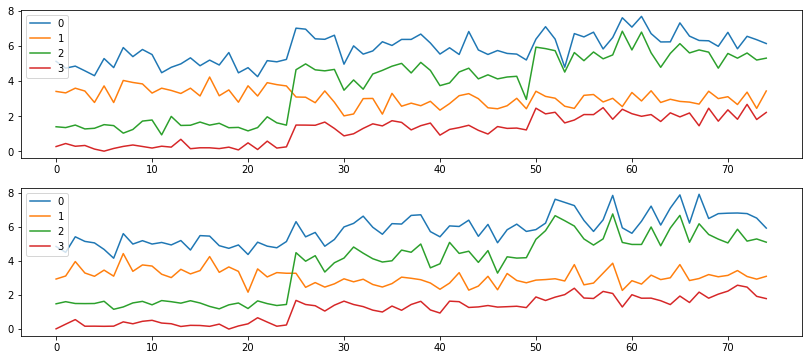

In [3]:
(X1,y1), (X2,y2) = make_seq1()
f,ax=plt.subplots(2,figsize=(14,6))
ax[0].plot(X1)
ax[1].plot(X2)
ax[0].legend(np.arange(4))
ax[1].legend(np.arange(4))
;

### Gaussian Distributions
#### 1. Training
Train on Set 1 and Test on Set 2

In [4]:
# create some data
#
# train a Gaussian model from the training data
gModel1 = SpchDens.Gaussian()
gModel1.fit(X1, y1)
gModel1.print_model()

Means
[[5.00865934 3.48330529 1.45489226 0.25696824]
 [6.01387395 2.7512824  4.3343099  1.34366961]
 [6.49654675 2.97597048 5.57039988 2.06830652]]
Variance
[[0.18498209 0.14183779 0.05985478 0.02285008]
 [0.2928278  0.14371592 0.25506943 0.05178478]
 [0.34771673 0.09981794 0.26877811 0.08959566]]


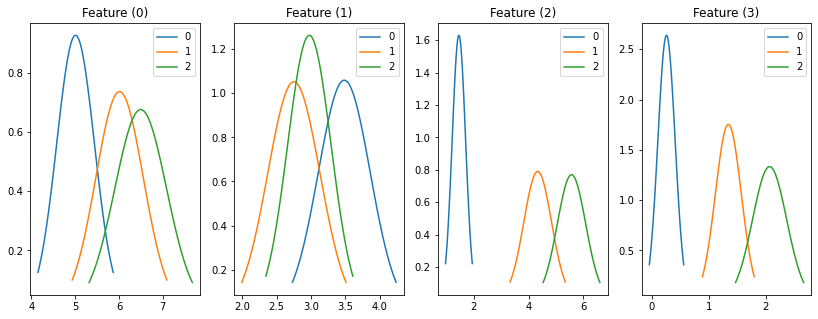

In [5]:
gModel1.plot_model()

In [6]:
gModel1.__dict__

{'priors': None,
 'var_smoothing': 1e-09,
 'classes_': array([0, 1, 2]),
 'n_features_in_': 4,
 'epsilon_': 3.1674971388520906e-09,
 'theta_': array([[5.00865934, 3.48330529, 1.45489226, 0.25696824],
        [6.01387395, 2.7512824 , 4.3343099 , 1.34366961],
        [6.49654675, 2.97597048, 5.57039988, 2.06830652]]),
 'var_': array([[0.18498209, 0.14183779, 0.05985478, 0.02285008],
        [0.2928278 , 0.14371592, 0.25506943, 0.05178478],
        [0.34771673, 0.09981794, 0.26877811, 0.08959566]]),
 'class_count_': array([25., 25., 25.]),
 'class_prior_': array([0.33333333, 0.33333333, 0.33333333])}

In [7]:
mu = np.array([
    [5.5, 3.5, 3.,1.],
    [6., 2.75, 4., 1.5  ],
    [6.5, 3.0, 5., 2.]
])
gModel2 = SpchDens.Gaussian(mu=mu)
#gModel2.var_ = np.ones((gModel2.theta_.shape))
#gModel2.n_features_in_ = 4
gModel2.class_prior_ = np.ones(gModel2.n_classes)/gModel2.n_classes
gModel2.__dict__

{'priors': None,
 'var_smoothing': 1e-09,
 'theta_': array([[5.5 , 3.5 , 3.  , 1.  ],
        [6.  , 2.75, 4.  , 1.5 ],
        [6.5 , 3.  , 5.  , 2.  ]]),
 'n_classes': 3,
 'n_features': 4,
 'classes_': array([0, 1, 2]),
 'var_': array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]),
 'class_prior_': array([0.33333333, 0.33333333, 0.33333333])}

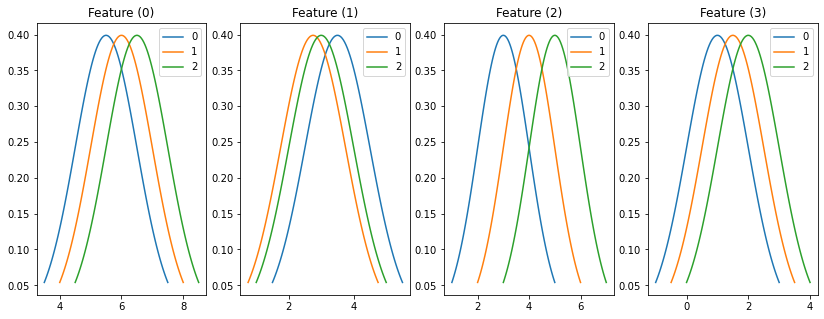

In [8]:
gModel2.plot_model()

### Posteriors and Log Posteriors

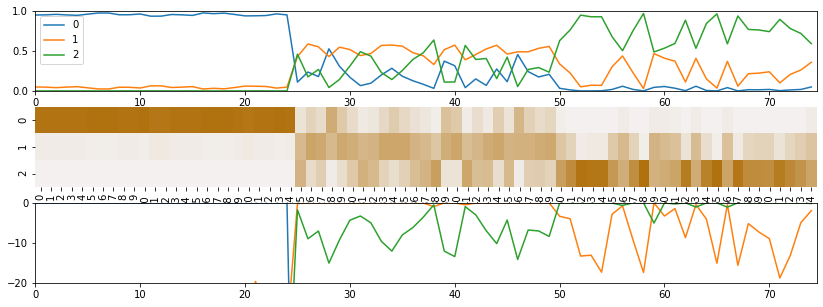

In [9]:
probs=gModel2.predict_proba(X2)
log_probs=gModel1.predict_log_proba(X2)
f,ax=plt.subplots(3,figsize=(14,5))
ax[0].plot(probs)
ax[0].set_xlim([0.,probs.shape[0]-.5])
ax[0].set_ylim([0,1.])
ax[0].legend(gModel1.classes_)
sns.heatmap(probs.T,ax=ax[1],vmax=1,vmin=0.0,yticklabels=gModel1.classes_,
            cmap=cmap,cbar=False, linewidth=0, linecolor='k')
ax[2].plot(log_probs)
ax[2].set_xlim([0.,probs.shape[0]-.5])
ax[2].set_ylim([-20,0.]);

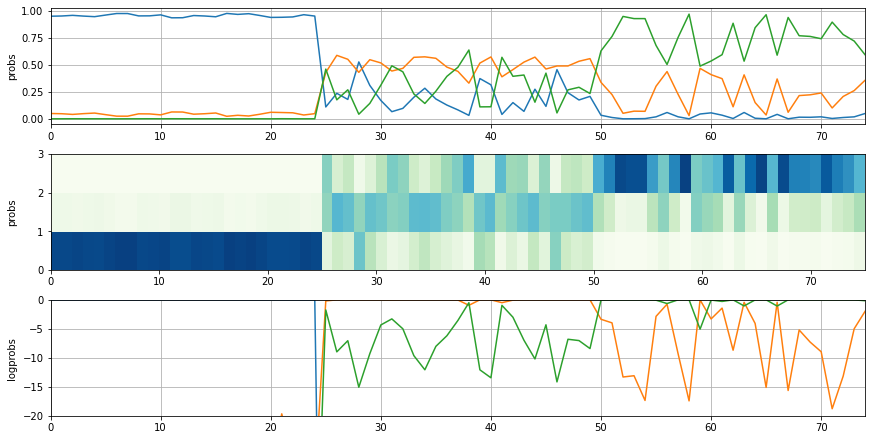

In [10]:
fig = Spchd.SpchFig(row_heights=[1.,1.,1.])
fig.add_line_plot(probs.T,iax=0,ylabel='probs')
fig.add_img_plot(probs.T,iax=1,cmap='GnBu',ylabel='probs')
fig.add_line_plot(log_probs.T,iax=2,yrange=[-20.,0.],ylabel='logprobs')
display(fig)

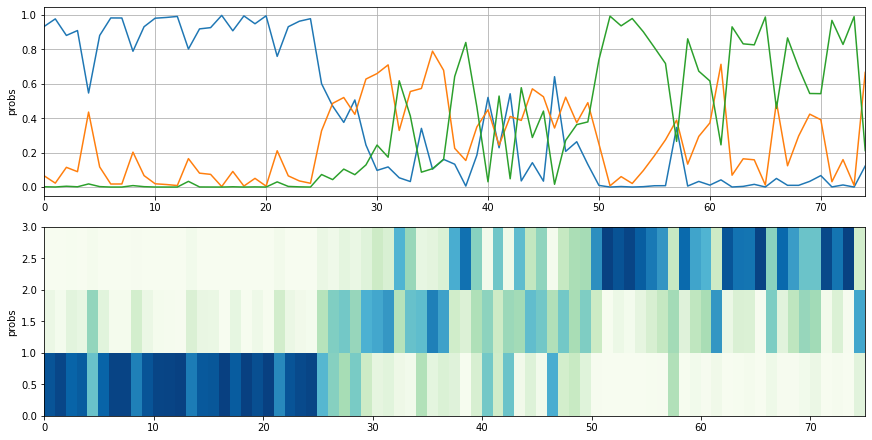

In [11]:
# let's make a bit harder by adding some noise to the test data
X3 = X2 + np.random.normal(loc=0.,scale=1,size=X2.shape)
probs=gModel2.predict_proba(X3)
log_probs=gModel1.predict_log_proba(X3)
fig = Spchd.SpchFig(row_heights=[1.,1.])
fig.add_line_plot(probs.T,iax=0,ylabel='probs')
fig.add_img_plot(probs.T,iax=1,cmap='GnBu',ylabel='probs')
display(fig)

### Classification

In [12]:
y_pred = gModel2.predict(X2)
print("Test Set: Number of mislabeled points out of a total %d points : %d" % (X2.shape[0], (y2 != y_pred).sum()))
y_pred = gModel2.predict(X3)
print("Noisy Set: Number of mislabeled points out of a total %d points : %d" % (X3.shape[0], (y2 != y_pred).sum()))

Test Set: Number of mislabeled points out of a total 75 points : 6
Noisy Set: Number of mislabeled points out of a total 75 points : 15


## Discrete Densities aka Categorical NB

In [13]:
(X1d,y1), (X2d,y2) = make_seq1d()
_, (X3d,y3) = make_seq1d(noise=1)
#

In [14]:
X1d = X1d[:,0:2]
X2d = X2d[:,0:2]
X3d = X3d[:,0:2]

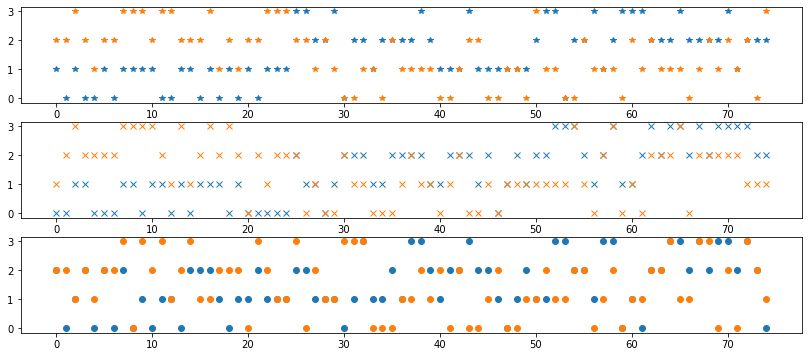

In [15]:
f,ax=plt.subplots(3,figsize=(14,6))
ax[0].plot(X1d,'*')
ax[1].plot(X2d,'x');
ax[2].plot(X3d,'o');

In [16]:
dd1 = Dist_Discr()
dd1.alpha = 1
dd1.fit(X=X1d,y=y1)

Dist_Discr(alpha=1)

In [17]:
dd1.get_params(), dd1.__dict__

({'alpha': 1, 'class_prior': None, 'fit_prior': True, 'min_categories': None},
 {'alpha': 1,
  'fit_prior': True,
  'class_prior': None,
  'min_categories': None,
  'n_features_in_': 2,
  'classes_': array([0, 1, 2]),
  'class_count_': array([25., 25., 25.]),
  'category_count_': [array([[10., 15.,  0.,  0.],
          [ 1., 10.,  9.,  5.],
          [ 1.,  2., 14.,  8.]]),
   array([[ 0.,  3., 12., 10.],
          [ 8., 11.,  6.,  0.],
          [ 5., 12.,  6.,  2.]])],
  'n_categories_': array([4, 4]),
  'feature_log_prob_': [array([[-0.96940056, -0.59470711, -3.36729583, -3.36729583],
          [-2.67414865, -0.96940056, -1.06471074, -1.57553636],
          [-2.67414865, -2.26868354, -0.65924563, -1.17007125]]),
   array([[-3.36729583, -1.98100147, -0.80234647, -0.96940056],
          [-1.17007125, -0.88238918, -1.42138568, -3.36729583],
          [-1.57553636, -0.80234647, -1.42138568, -2.26868354]])],
  'class_log_prior_': array([-1.09861229, -1.09861229, -1.09861229])})

 ++ Feature(0) ++ 
[[0.37931034 0.55172414 0.03448276 0.03448276]
 [0.06896552 0.37931034 0.34482759 0.20689655]
 [0.06896552 0.10344828 0.51724138 0.31034483]]
 ++ Feature(1) ++ 
[[0.03448276 0.13793103 0.44827586 0.37931034]
 [0.31034483 0.4137931  0.24137931 0.03448276]
 [0.20689655 0.44827586 0.24137931 0.10344828]]


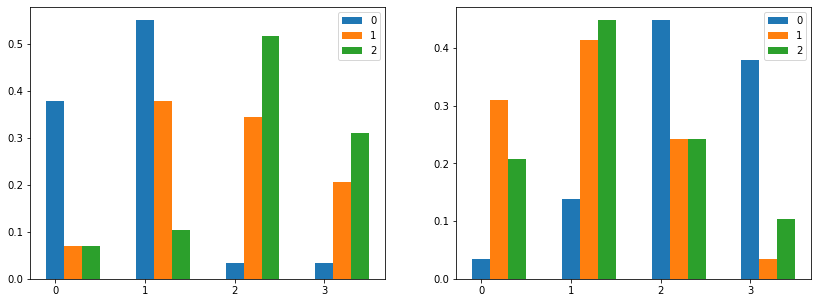

In [18]:
dd1.plot_model()
dd1.print_model()

In [19]:
dd1.get_class_proba(0)

[array([0.37931034, 0.55172414, 0.03448276, 0.03448276]),
 array([0.03448276, 0.13793103, 0.44827586, 0.37931034])]

In [20]:
dd1.print_model(per_class=True)

 ++ Class(0) ++ 
[0.37931034 0.55172414 0.03448276 0.03448276]
[0.03448276 0.13793103 0.44827586 0.37931034]
 ++ Class(1) ++ 
[0.06896552 0.37931034 0.34482759 0.20689655]
[0.31034483 0.4137931  0.24137931 0.03448276]
 ++ Class(2) ++ 
[0.06896552 0.10344828 0.51724138 0.31034483]
[0.20689655 0.44827586 0.24137931 0.10344828]


In [21]:
y_pred = dd1.predict(X2d)
print("Test Set: Number of mislabeled points out of a total %d points : %d" % (X2d.shape[0], (y2 != y_pred).sum()))
y_pred = dd1.predict(X3d)
print("Noisy Set: Number of mislabeled points out of a total %d points : %d" % (X3d.shape[0], (y2 != y_pred).sum()))

Test Set: Number of mislabeled points out of a total 75 points : 17
Noisy Set: Number of mislabeled points out of a total 75 points : 36


In [22]:
dd1.score(X3d,y3)

0.52

In [26]:
dd2 = SpchDens.Discrete(feature_probs=np.exp(dd1.feature_log_prob_))

In [27]:
dd2.__dict__

{'n_features': 2,
 'alpha': 1.0,
 'feature_prob_': array([[[0.37931034, 0.55172414, 0.03448276, 0.03448276],
         [0.06896552, 0.37931034, 0.34482759, 0.20689655],
         [0.06896552, 0.10344828, 0.51724138, 0.31034483]],
 
        [[0.03448276, 0.13793103, 0.44827586, 0.37931034],
         [0.31034483, 0.4137931 , 0.24137931, 0.03448276],
         [0.20689655, 0.44827586, 0.24137931, 0.10344828]]]),
 'n_categories': array([4, 4], dtype=int32),
 'n_classes': 3,
 'class_prior_': array([0.33333333, 0.33333333, 0.33333333]),
 'labels': [array(['L0', 'L1', 'L2', 'L3'], dtype='<U2'),
  array(['L0', 'L1', 'L2', 'L3'], dtype='<U2')],
 'classes_': array([0, 1, 2])}


 ++ Feature (0) ++


,0,1,2
P(L0|.),0.379310,0.068966,0.068966
P(L1|.),0.551724,0.379310,0.103448
P(L2|.),0.034483,0.344828,0.517241
P(L3|.),0.034483,0.206897,0.310345



 ++ Feature (1) ++


,0,1,2
P(L0|.),0.034483,0.310345,0.206897
P(L1|.),0.137931,0.413793,0.448276
P(L2|.),0.448276,0.241379,0.241379
P(L3|.),0.379310,0.034483,0.103448


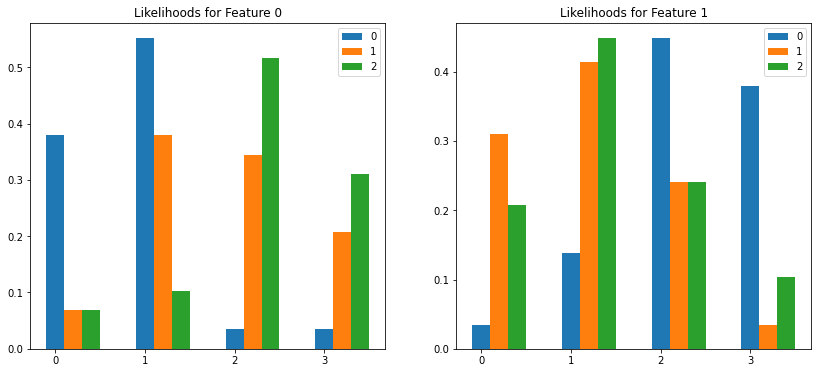

In [28]:

dd2.print_model()
dd2.plot_model()

In [29]:
dd2.__dict__

{'n_features': 2,
 'alpha': 1.0,
 'feature_prob_': array([[[0.37931034, 0.55172414, 0.03448276, 0.03448276],
         [0.06896552, 0.37931034, 0.34482759, 0.20689655],
         [0.06896552, 0.10344828, 0.51724138, 0.31034483]],
 
        [[0.03448276, 0.13793103, 0.44827586, 0.37931034],
         [0.31034483, 0.4137931 , 0.24137931, 0.03448276],
         [0.20689655, 0.44827586, 0.24137931, 0.10344828]]]),
 'n_categories': array([4, 4], dtype=int32),
 'n_classes': 3,
 'class_prior_': array([0.33333333, 0.33333333, 0.33333333]),
 'labels': [array(['L0', 'L1', 'L2', 'L3'], dtype='<U2'),
  array(['L0', 'L1', 'L2', 'L3'], dtype='<U2')],
 'classes_': array([0, 1, 2])}

In [30]:
import copy
dd3= copy.copy(dd2)
dd3.fit(X=X1d,y=y1)
dd3.__dict__

sorry


{'n_features': 2,
 'alpha': 1.0,
 'feature_prob_': array([[[0.37931034, 0.55172414, 0.03448276, 0.03448276],
         [0.06896552, 0.37931034, 0.34482759, 0.20689655],
         [0.06896552, 0.10344828, 0.51724138, 0.31034483]],
 
        [[0.03448276, 0.13793103, 0.44827586, 0.37931034],
         [0.31034483, 0.4137931 , 0.24137931, 0.03448276],
         [0.20689655, 0.44827586, 0.24137931, 0.10344828]]]),
 'n_categories': array([4, 4], dtype=int32),
 'n_classes': 3,
 'class_prior_': array([0.33333333, 0.33333333, 0.33333333]),
 'labels': [array(['L0', 'L1', 'L2', 'L3'], dtype='<U2'),
  array(['L0', 'L1', 'L2', 'L3'], dtype='<U2')],
 'classes_': array([0, 1, 2])}

In [104]:
dd3.alpha=.2
dd3.__dict__

{'n_features': 2,
 'alpha': 0.2,
 'feature_prob_': array([[[0.48275862, 0.44827586, 0.03448276, 0.03448276],
         [0.06896552, 0.44827586, 0.31034483, 0.17241379],
         [0.06896552, 0.03448276, 0.62068966, 0.27586207]],
 
        [[0.03448276, 0.13793103, 0.31034483, 0.51724138],
         [0.31034483, 0.4137931 , 0.24137931, 0.03448276],
         [0.17241379, 0.44827586, 0.34482759, 0.03448276]]]),
 'n_categories': array([4, 4], dtype=int32),
 'n_classes': 3,
 'class_prior_': array([0.33333333, 0.33333333, 0.33333333]),
 'labels': [array(['L0', 'L1', 'L2', 'L3'], dtype='<U2'),
  array(['L0', 'L1', 'L2', 'L3'], dtype='<U2')],
 'classes_': array([0, 1, 2])}

In [ ]:
sns.heatmap(dd1.predict_proba(X3d).T,cmap='Greys',vmax=1.2)

### HMM Recognition

In [ ]:
from pyspch import libhmm 
from pyspch import utils as spchu
#from pyspch import Dist

dd1.print_model(per_class=True)


In [ ]:
imat = np.array([1.0, 0.0, 0.])
tmat = np.array([[.8,.2,0.],[0.,.8,.2],[0.,0.,1.]])

hmm1 = libhmm.HMM(n_states=3,prob_style="lin",obs_model=dd1,
                  transmat=tmat,initmat=imat)
hmm1.print_model()

In [ ]:
X=X2d
tr = libhmm.Trellis(hmm1)
tr.viterbi_pass(X2d)
tr.backtrace()

In [ ]:
tr.plot_trellis(plot_norm=True,plot_obs_probs=True,plot_values=False,vmin=0.,vmax=1,figsize=(15,5))

In [ ]:
# change the transition probability in State 2
hmm2 = copy.copy(hmm1)
hmm2.transmat =  np.array([[.8,.2,0.],[0.,.9,.1],[0.,0.,1.]])
tr2 = libhmm.Trellis(hmm2)
tr2.viterbi_pass(X2d)
tr2.backtrace()
tr2.plot_trellis(plot_norm=True,plot_obs_probs=True,plot_values=False,vmin=0.,vmax=1,figsize=(15,5))

In [ ]:
# change the transition probabilities to ergodic
hmm3 = copy.copy(hmm1)
hmm3.init_topology(type="ergodic")
#hmm3.transmat[2,2]=.5
#hmm3.transmat =  np.array([[.8,.2,0.],[0.,.9,.1],[0.,0.,1.]])
tr3 = libhmm.Trellis(hmm3)
tr3.viterbi_pass(X2d)
print(tr3.backtrace())
tr3.plot_trellis(plot_norm=True,plot_obs_probs=True,plot_values=False,vmin=0.,vmax=2,figsize=(15,3))

In [ ]:
tr3.__dict__

In [ ]:
hmm1.obs_model.__dict__

In [ ]:
# filling the trellis in a time synchronous way
X=X2d
tr_ = libhmm.Trellis(hmm1)
#N = obs_probs.shape[0]
for i in range(10):
    clear_output(wait=True)
    tr_.viterbi_step(X[i,:])
    tr_.print_trellis(what=['obs_probs','probs'],Titles=True)
    tr_.plot_trellis(xticks=X[0:i],plot_obs_probs=True,plot_backptrs=True,plot_alignment=True,
                plot_norm=True,vmin=0.,vmax=2)
    #time.sleep(2)

In [ ]:
tst = probs[0:75:10,:]
tst

In [ ]:
# converting posteriors to normalized likelihoods
# computing likelihoods is only possible if the total sample likelihoods would be available 
def post_to_lik(post,priors=None):
    if priors is None:
        return(post)
    lik = post / priors
    lik = lik / np.sum(lik,axis=1,keepdims=True)
    return(lik)

def lik_to_post(lik,priors=None):
    if priors is None:  post = lik
    else:               post = lik * priors
    post = post / np.sum(post,axis=1,keepdims=True)
    return(post)

In [ ]:
pp = post_to_lik(tst)
pp

In [ ]:
lik_to_post(pp)

In [ ]:
tst